In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv(r"C:\Users\NSHAT\Estarta - internship\project 2 - cars\data\vehicle_dataset.csv")

In [3]:
df.sample(5)

,id,url,region,region_url,price,year,manufacturer,model,cylinders,fuel,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,condition
237849,7310809396,https://binghamton.craigslist.org/ctd/d/bingha...,binghamton,https://binghamton.craigslist.org,23990,2017.0,jaguar,xf 20d premium sedan 4d,NaN,other,...,sedan,black,https://images.craigslist.org/00n0n_3kxEXrkBi7...,Carvana is the safer way to buy a car During t...,NaN,ny,42.100000,-75.910000,2021-04-22T10:12:44-0400,Good
45427,7316317184,https://sacramento.craigslist.org/ctd/d/sacram...,sacramento,https://sacramento.craigslist.org,8985,2013.0,mazda,cx-5,NaN,gas,...,SUV,blue,https://images.craigslist.org/00y0y_7GqkjghK7g...,2013 *** Mazda CX-5 Grand Touring 4dr SUV SUV ...,NaN,ca,38.523775,-121.442382,2021-05-03T11:00:58-0700,Poor
267381,7313012172,https://dayton.craigslist.org/ctd/d/chillicoth...,dayton / springfield,https://dayton.craigslist.org,51999,2019.0,ford,f-250sd,NaN,gas,...,pickup,NaN,https://images.craigslist.org/00l0l_70Xh2zoT5P...,2019 *** Ford F-250SD XLT Pickup *** Drive it ...,NaN,oh,39.337094,-82.949176,2021-04-26T16:30:16-0400,Good
39202,7305946683,https://palmsprings.craigslist.org/ctd/d/palm-...,palm springs,https://palmsprings.craigslist.org,4499,2006.0,chrysler,pt cruiser limited,4 cylinders,gas,...,van,NaN,https://images.craigslist.org/00t0t_3gdNeF3H7E...,"🚗 2006 Chrysler PT Cruiser Limited98,539 mi. -...",NaN,ca,33.745583,-116.361979,2021-04-12T17:03:14-0700,Poor
163664,7312807867,https://chambersburg.craigslist.org/ctd/d/ship...,cumberland valley,https://chambersburg.craigslist.org,9500,2010.0,bmw,x5,6 cylinders,diesel,...,SUV,silver,https://images.craigslist.org/01111_5hqyto9cdP...,Fully Deleted and VR Tuned! Up For sale 201...,NaN,md,40.023465,-77.516006,2021-04-26T11:15:05-0400,Poor


In [4]:
df.shape

(380180, 26)

In [5]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date', 'condition'],
      dtype='object')

In [6]:
df.drop(columns={"url","region_url","image_url","description","VIN","lat","long","posting_date"},inplace=True) # not useful for classification or regression

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380180 entries, 0 to 380179
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            380180 non-null  int64  
 1   region        380180 non-null  object 
 2   price         380180 non-null  int64  
 3   year          380180 non-null  float64
 4   manufacturer  366742 non-null  object 
 5   model         376170 non-null  object 
 6   cylinders     225029 non-null  object 
 7   fuel          378061 non-null  object 
 8   odometer      380180 non-null  float64
 9   title_status  373305 non-null  object 
 10  transmission  378670 non-null  object 
 11  drive         264595 non-null  object 
 12  size          106581 non-null  object 
 13  type          298777 non-null  object 
 14  paint_color   269300 non-null  object 
 15  county        0 non-null       float64
 16  state         380180 non-null  object 
 17  condition     373305 non-null  object 
dtypes: f

# pre - processing

In [8]:
df["year"] = pd.to_numeric(df["year"], errors='coerce').astype("Int64")

### Missing Values

In [9]:
df.isna().sum()

id                   0
region               0
price                0
year                 0
manufacturer     13438
model             4010
cylinders       155151
fuel              2119
odometer             0
title_status      6875
transmission      1510
drive           115585
size            273599
type             81403
paint_color     110880
county          380180
state                0
condition         6875
dtype: int64

In [10]:
df.drop(columns={"county"},inplace = True)

In [11]:
df.drop(columns={"size","cylinders"},inplace=True) # very high missing values (condition column wont be dropped because its a target variable)

In [12]:
df = df.dropna(subset=['year', 'manufacturer', 'model','condition']) # those are missing critical info

In [13]:
# fill catogrical with mode
cat_cols = ['fuel', 'transmission', 'title_status']

for col in cat_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value) 


In [14]:
# fill with median for odometer
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

In [15]:
for col in ['drive', 'type', 'paint_color']:
    top_freq = df[col].value_counts(normalize=True).iloc[0]
    print(f"{col} mode frequency: {top_freq:.2%}")


drive mode frequency: 44.55%
type mode frequency: 26.21%
paint_color mode frequency: 26.14%


In [16]:
# mode isnt so dominant so filling with "Missing"
for col in ['drive', 'type', 'paint_color']:
    df[col] = df[col].fillna('Missing')

In [17]:
df.shape

(356036, 15)

## duplicates

In [18]:
df.duplicated().sum()

np.int64(0)

## outliers 

In [19]:
print(f"max price is {df["price"].max()}  min price is {df["price"].min()}")

max price is 109999  min price is 301


In [20]:
print(f"max year is {df["year"].max()}  min year is {df["year"].min()}")

max year is 2022  min year is 1960


In [21]:
print(f"max odometer is {df["odometer"].max()}  min odometer is {df["odometer"].min()}")

max odometer is 499232.0  min odometer is 0.0


In [22]:
# dealing with the very extreem outliers only

In [23]:
df = df[(df['price'] > 300) & (df['price'] < 110000)]  
df = df[df['odometer'] < 500000] 

In [24]:
df = df[df["year"].between(1960,2025)]

In [25]:
df.shape

(356036, 15)

# Plotting and Gaining Insights

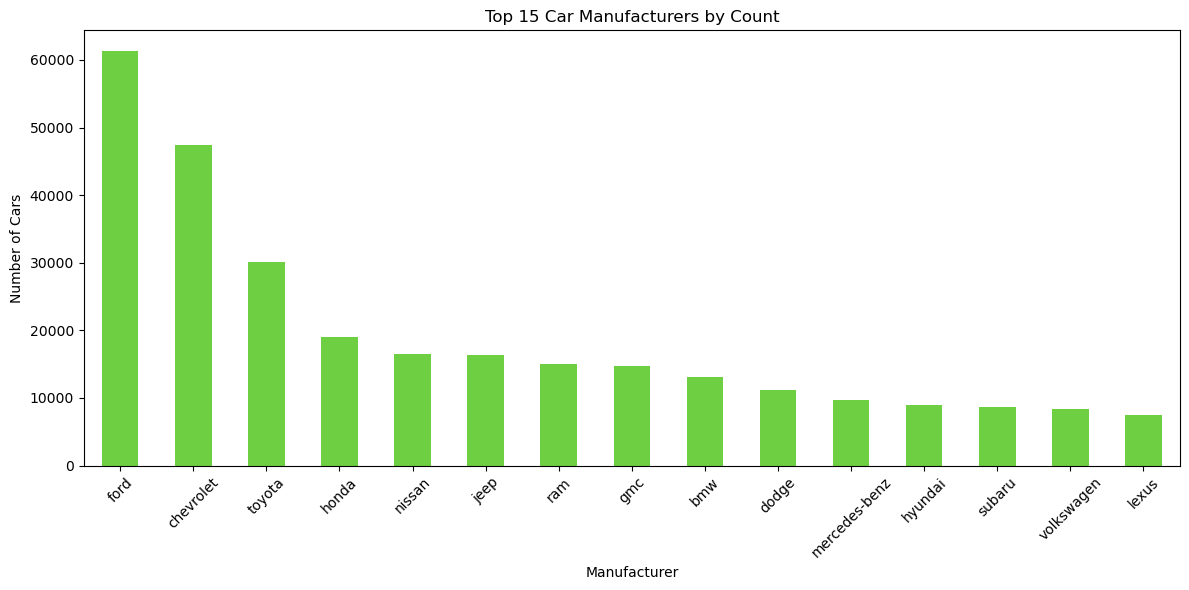

In [26]:
# Count occurrences of each manufacturer and get top 15
top15 = df['manufacturer'].value_counts().head(15)

# Plot bar chart
plt.figure(figsize=(12,6))
top15.plot(kind='bar', color='#6FCF42')
plt.title('Top 15 Car Manufacturers by Count')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

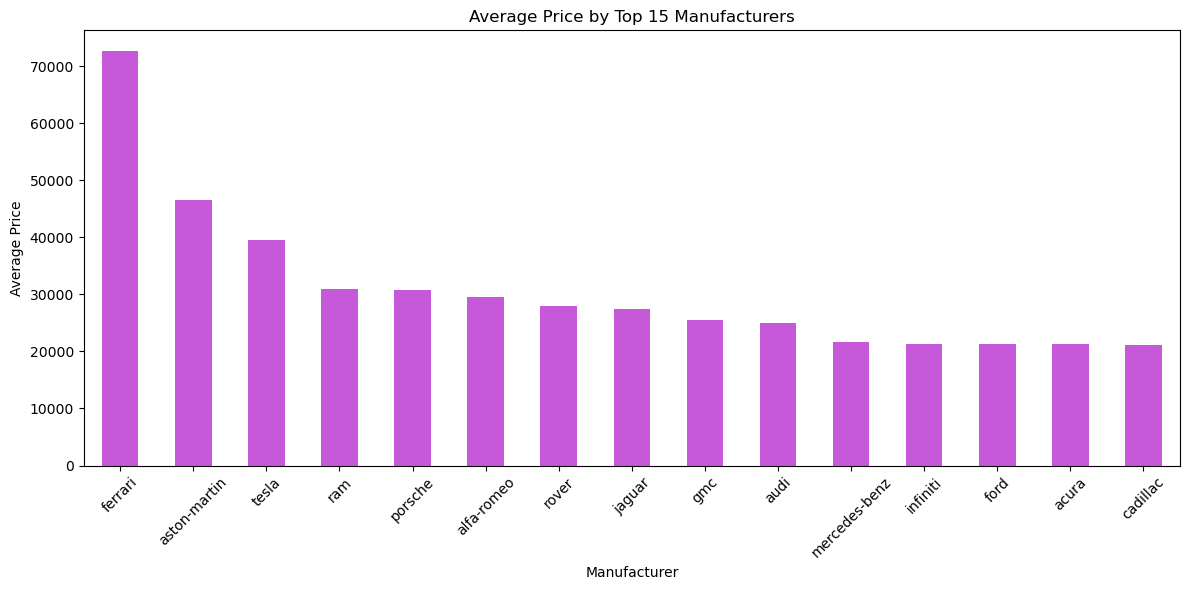

In [27]:
avg_price = df.groupby('manufacturer')['price'].mean()
top15 = avg_price.sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
top15.plot(kind='bar', color='#C659D9')
plt.title('Average Price by Top 15 Manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


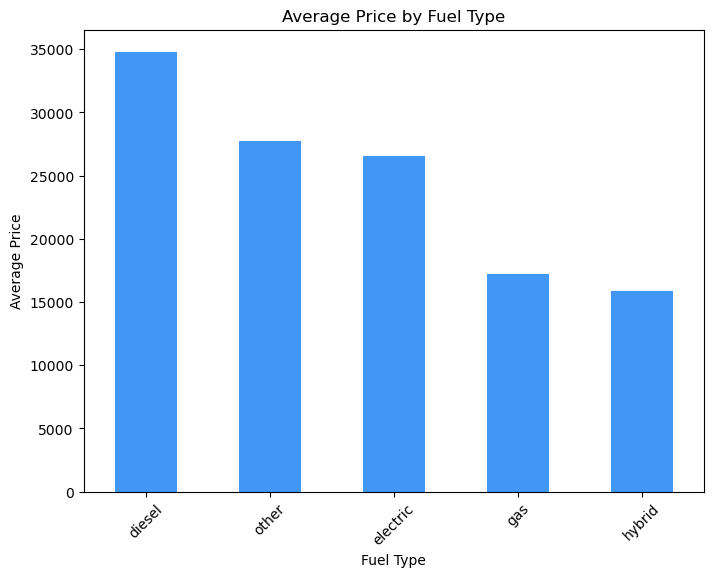

In [55]:
avg_price = df.groupby('fuel')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
avg_price.plot(kind='bar', color='#4097F5')
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

plt.show()

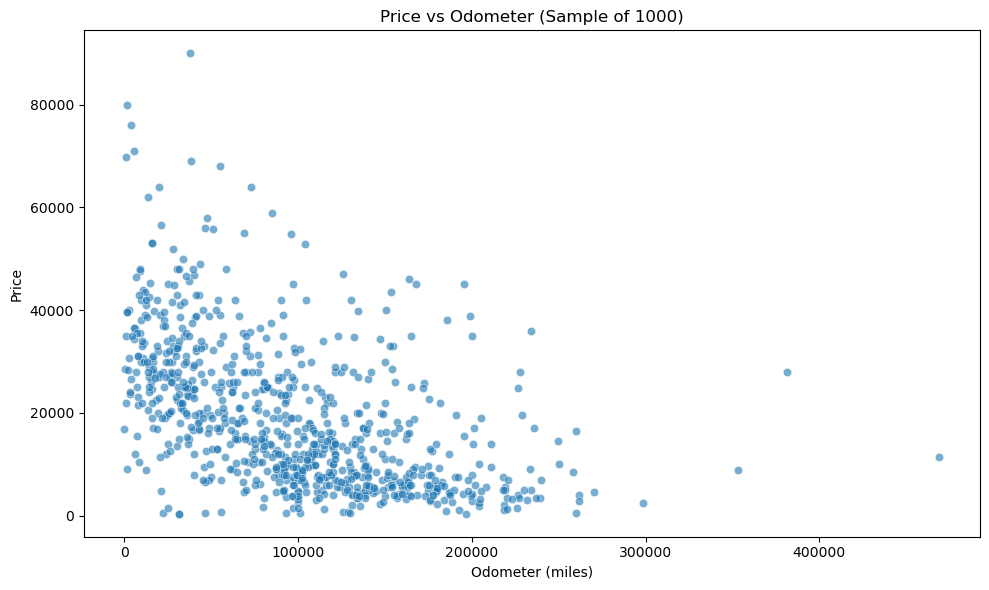

In [29]:
df_sample = df.sample(n=800, random_state=42)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_sample, x='odometer', y='price', alpha=0.6)

plt.title('Price vs Odometer (Sample of 1000)')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Feature Engineering

In [30]:
df['car_age'] = 2025 - df['year']

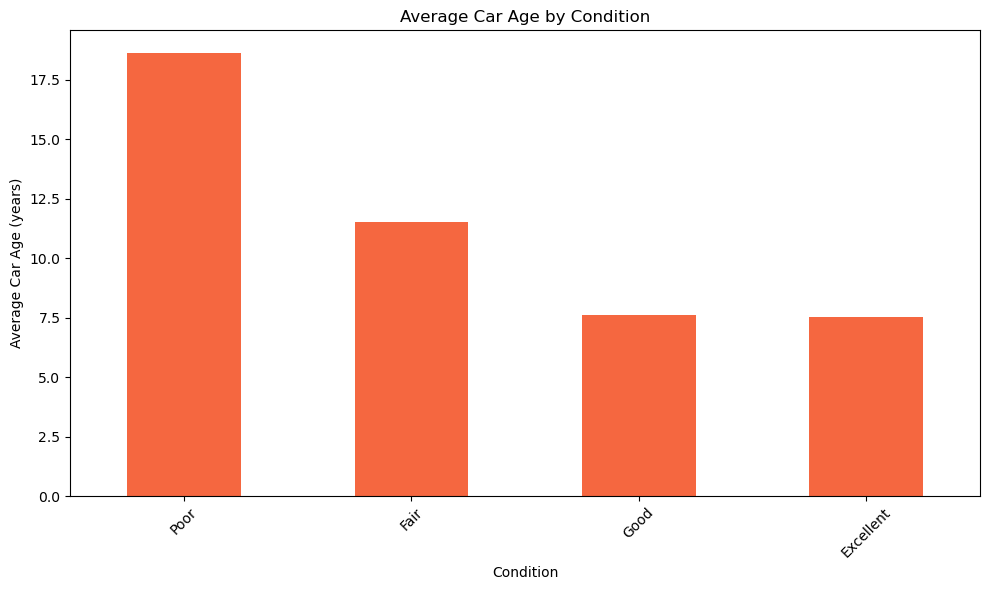

In [31]:
avg_age = df.groupby('condition')['car_age'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
avg_age.plot(kind='bar', color='#F56740')
plt.title('Average Car Age by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Car Age (years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Condtion Prediction - Classification

In [32]:
df["condition"].unique()

array(['Fair', 'Excellent', 'Good', 'Poor'], dtype=object)

In [33]:
X = df.drop(columns=['condition','price','id'])
y = df['condition']

### Encoding catogrical features

In [34]:
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

In [35]:
y_le = LabelEncoder()
y_encoded = y_le.fit_transform(y.astype(str))
rev_label_mapping = dict(zip(y_le.transform(y_le.classes_), y_le.classes_))

### splitting the data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

### Evaluation Function

In [37]:
def plot_evaluation(y_true, y_pred, labels=None, figsize=(8,6)):
    
    # Print accuracy and classification report
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Decision Tree

In [38]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

Accuracy: 0.8922873834400629
              precision    recall  f1-score   support

   Excellent       0.63      0.66      0.65      3878
        Fair       0.91      0.91      0.91     22500
        Good       0.88      0.89      0.88     15992
        Poor       0.93      0.91      0.92     28838

    accuracy                           0.89     71208
   macro avg       0.84      0.84      0.84     71208
weighted avg       0.89      0.89      0.89     71208



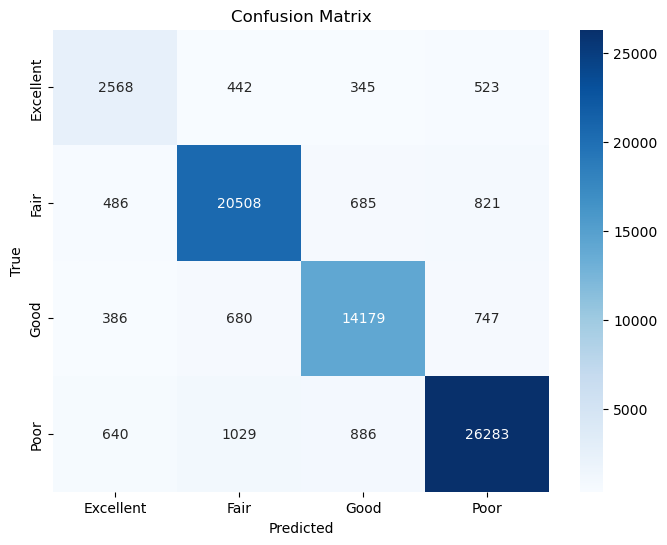

In [39]:
y_test_named = pd.Series(y_test).map(rev_label_mapping)
y_pred_named = pd.Series(y_pred).map(rev_label_mapping)
label_names = list(rev_label_mapping.values())
plot_evaluation(y_test_named, y_pred_named, labels=label_names)

## XGBoost

In [40]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


Accuracy: 0.9482782833389507
              precision    recall  f1-score   support

   Excellent       0.95      0.70      0.80      3878
        Fair       0.95      0.96      0.95     22500
        Good       0.95      0.94      0.94     15992
        Poor       0.95      0.97      0.96     28838

    accuracy                           0.95     71208
   macro avg       0.95      0.89      0.92     71208
weighted avg       0.95      0.95      0.95     71208



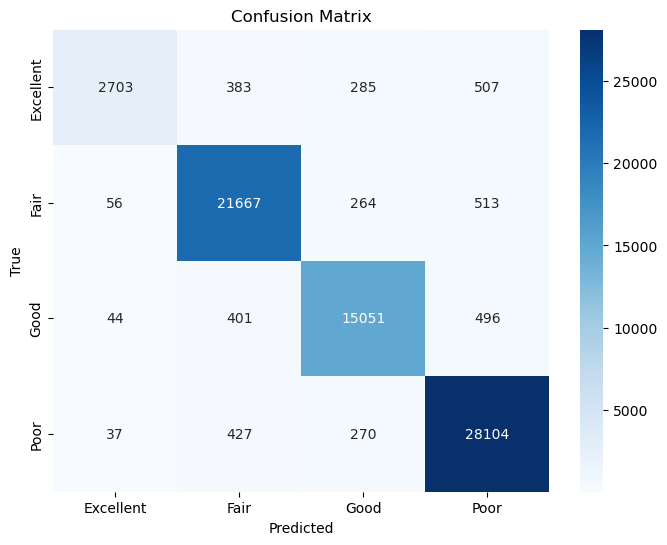

In [41]:
y_test_named = pd.Series(y_test).map(rev_label_mapping)
y_pred_named = pd.Series(y_pred).map(rev_label_mapping)
label_names = list(rev_label_mapping.values())
plot_evaluation(y_test_named, y_pred_named, labels=label_names)


# Price Predictions - Regression

# Feature Selection 

In [42]:
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'condition', 'car_age'],
      dtype='object')

In [43]:
features = ['car_age', 'drive', 'type', 'manufacturer','model', 'fuel', 'odometer','transmission','paint_color', 'state']

In [44]:
X = df[features]
y = df['price']

# Label Encoding for catogrical features

In [45]:
cat_cols = ['manufacturer', 'model', 'fuel', 'drive', 'transmission', 'type', 'paint_color', 'state']

for col in cat_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

## train test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling (Price Predections)

## Random Forest

In [47]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest")
print(f"MAE: {mean_absolute_error(y_test, rf_preds):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):,.2f}")
print(f"R^2: {r2_score(y_test, rf_preds):.4f}")

Random Forest
MAE: 2,004.46
RMSE: 4,524.44
R^2: 0.8990


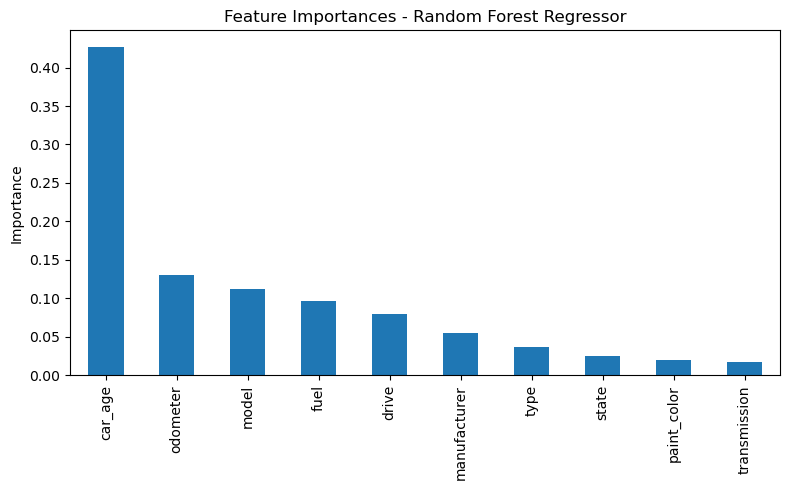

In [48]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_importances.plot(kind='bar')
plt.title('Feature Importances - Random Forest Regressor')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# XGBoost

In [49]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_preds):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):,.2f}")
print(f"R^2: {r2_score(y_test, xgb_preds):.4f}")

XGBoost
MAE: 3,345.72
RMSE: 5,607.85
R^2: 0.8449


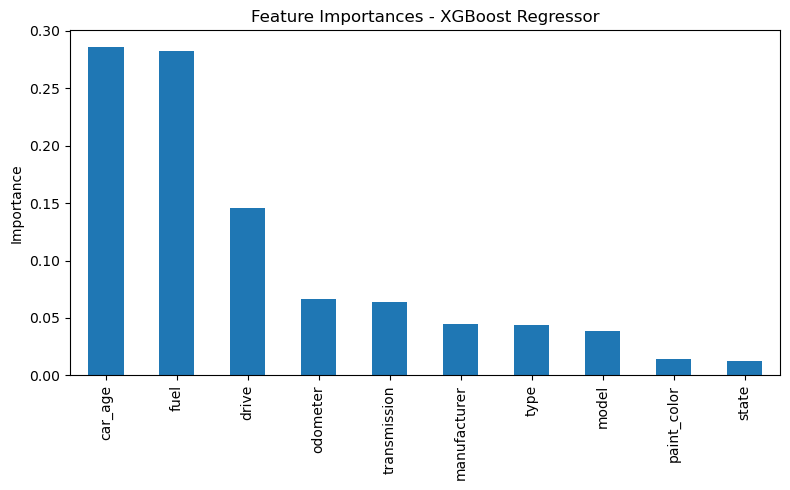

In [50]:
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_importances.plot(kind='bar')
plt.title('Feature Importances - XGBoost Regressor')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()